# Problem Set 5: Bayesian Inference And Bits-Back Coding

**This problem set is part of the course "Data Compression With Deep Probabilistic Models" by Prof. Robert Bamler at University of Tuebingen, Germany. You can find more course materials (lecture notes, video recordings, and solutions) at the course website, https://robamler.github.io/teaching/compress21/**

**Problem Set Published:** 20 May 2021<br>
**Discussion:** 31 May 2021

*This problem set is provided both as a jupyter notebook and as a PDF rendering of the same notbook. The jupyter notebook contains several blanks where you have to fill in your code to solve the problems. I kept all output that I obtained from running my solutions in the notebook and the PDF, so that you can compare them to your results. For this purpose, you may find it useful to refer to the PDF rendering of the notebook, because my program output will obviously disappear from this notebook as soon as you run your code.*

In response to several questions in the lecture on Tuesday, and deviating from the foreshadowing on last week's problem set, we will defer the planned discussion of mutual information to the next problem set and use this problem set to practice Bayesian inference and the bits-back coding method.
In this problem set, you will implement several compression methods that use a latent variable model, and you will compare the empirical compression performance across these methods by comparing the resulting bit rates for some sample messages.
The methods that you will implement are:
1. a naive method that simply ignores correlations between symbols in a message;
2. encoding and transmitting a MAP estimated latent variable, then encoding the message conditioned on the MAP estimate; and
3. bits-back coding.

You won't have to write much code for this problem set because all the setup is already done for you.
You only need to fill in the most critical parts.
But, in order to do this, you have to understand what all the setup does.
So read the instructions carefully and make sure you understand every part before you move on to the next.

## Problem 1: Prerequisites

You won't yet write much code in this problem, we'll just set up everything here so that you can get your hands dirty in Problems 2-4.

This problem set focuses on the interplay between source coding and probabilistic modelling.

- we will focus on the question: "which random variables have to be encoded or decoded with which probabilistic models at what time?"
- we will *not* (for now) address the question: "*how* do we encode the random variables into a bit string (once we've figured out *what* random variables we want to encode and with which model)."

Don't worry: you'll learn the answer to the second question in the next lecture.
For now, just think of the encoding algorithm that you'll use below as something similar to Huffman Coding, just with smaller overhead.

### Problem 1 (a): a library of entropy coding primitives

To actually perform the encoding and decoding, we'll use the [`constriction` library](https://bamler-lab.github.io/constriction/), which was specially developed with research and teaching use cases in mind.
This library is still its early days (quite literally!), so you may find some bugs.
Please [report issues](https://github.com/bamler-lab/constriction/issues) (or ping me on discord) if `constriction` doesn't work on your system, so I can try to fix it.

To test if `constriction` works on your system, please follow these steps:

1. Make sure you use Python version 3.7, 3.8, or 3.9, on either Linux, Windows, or Mac OS. Other systems are currently not supported.

2. Install `constriction` via pip:

In [1]:
!pip install constriction numpy

3. Once `constriction` is installed, import it and run the example code below.
   - Carefully read the example code and make sure you understand how to use the showcased parts of the library.
   - If the example code doesn't work on your system, then please let me know, either on discord or by [filing an issue](https://github.com/bamler-lab/constriction/issues).

In [2]:
import constriction
import numpy as np

# Specify a probabilistic model of a data source (typically referred to as an "entropy model").
lowest_symbol = 0  # Our alphabet consists of consecutive integers, starting at `lowest_symbol`.
symbol_probabilities = np.array([0.3, 0.4, 0.2, 0.1], dtype=np.float64) # (must be 64-bit floats)

# Define two toy example messages; symbols must be 32-bit signed integers within the range from
# `lowest_symbol` (inclusively) to `lowest_symbol + len(symbol_probabilities)` (exclusively).
message1 = np.array([3, 0, 1, 0, 2, 3, 2, 2], dtype=np.int32)
message2 = np.array([1, 3, 2, 1, 3], dtype=np.int32)

# Construct an entropy coder that uses the Asymmetric Numeral Systems (ANS) method (more on this
# method in the next lecture). Then encode both messages with the coder and the entropy model.
# Please note:
# - we encode the messages *in reverse order* (first `message2`, then `message1`() because the
#   ANS coder operates as a stack ("last in first out"); and
# - we encode both messages with the same entropy model to keep things simple; but you could as
#   well use a different entropy model for each message, as long as you then also use the
#   correct entropy model for each message upon decoding (see below).
coder = constriction.stream.stack.AnsCoder()
coder.encode_iid_categorical_symbols_reverse(message2, lowest_symbol, symbol_probabilities)
coder.encode_iid_categorical_symbols_reverse(message1, lowest_symbol, symbol_probabilities)

# Get the compressed data as an array of unsigned 32-bit integers (this is how `constriction`
# represents compressed data by default).
compressed = coder.get_compressed()
print(f'Compressed data has {len(compressed) * 32} bits (including padding to a multiple of 32 bits).')
print(compressed) # should print "[3521629398     430756]"

# Create a decoder and decode the messages.
# Please note:
# - we're *popping the meessages off the stack*, so we'll first get `message1` and then `message2`;
# - the `AnsCoder` class actually doesn't distinguish between an encoder and a decoder, i.e., you
#   could also use the original `coder` for decoding; and
# - the first argument for the method `decode_iid_categorical_symbols` is the number of symbols you
#   want to decode.
decoder = constriction.stream.stack.AnsCoder(compressed)
reconstruction1 = decoder.decode_iid_categorical_symbols(8, lowest_symbol, symbol_probabilities)
reconstruction2 = decoder.decode_iid_categorical_symbols(5, lowest_symbol, symbol_probabilities)

# Verify correctness.
assert np.all(reconstruction1 == message1)
assert np.all(reconstruction2 == message2)
print("Both messages reconstructed successfully.")

Compressed data has 64 bits (including padding to a multiple of 32 bits).
[3521629398     430756]
Both messages reconstructed successfully.


#### Your Task

To verify that you understand how the library works, change the above example so that it still encodes both `message1` and `message2`, but now with *different* entropy models.
While `message1` should be encoded and decoded as before, `message2` should now be encoded and decoded with a model that supports only the alphabet $\{1, 2, 3\}$ (i.e., it doesn't support the symbol "$0$"), and the probabilities are $P(x_i=1)=0.5$, $P(x_i=2)=0.2$, and $P(x_i=3)=0.3$.
Your implementation should print the compressed representation as being `[2884514895      59071]`, and it should then be able to successfully reconstruct both messages.

If you want to play around more with this library then you may want to refer to the [API documentation](https://bamler-lab.github.io/constriction/apidoc/python/) (which is still a bit incomplete, though). 

### Problem 1 (b): Generative Model

This part of the problem sets up everything we need for Problems 2, 3, and 4 below, where you will implement three different compression techniques.

The first step is to define a probabilistic model of a data source.
We will use a very simple probabilistic model so that you can focus on the coding techniques and you don't get distracted by complicated model architectures.
Unfortunately, this means that the model is somewhat contrived.
Don't get discouraged by this!
The same techniques that you will learn at the example of this toy model have recently been applied to powerful deep learning models, resulting in some of the most competitive image and video compression methods.
Trying them out on a simplified toy model will allow you to easily change parameters so that you can explore why certain methods work better or worse in different regimes (see Problem 5 below).

We consider messages $\mathbf x=(x_1,x_2,\ldots,x_k)$ that are sequences of $k$ binary symbols, $x_i \in\{\texttt{True}, \texttt{False}\}\;\forall i\in\{1,\ldots,k\}$.
Our probabilistic model of the data source assumes that each symbol $x_i$ was generated by throwing a die and then setting:

\begin{align}
    x_i &= \begin{cases}
        \texttt{True} & \text{if the die throw resulted in $1$, $2$, $3$, $4$, or $5$} \\
        \texttt{False} & \text{else.}
    \end{cases}
\end{align}

However, the die that is used to generate these symbols is not a standard six-sided die.
Instead, it is a fair $z$-sided die, where $z$ can be any integer between $10$ and $60$ (both inclusively).
Importantly, the value of $z$ is *not* part of the message, but it is the *same for all symbols $x_i$ within the message*.
In this sense, $z$ is similar to the latent "topic" of the newspaper headlines that we discussed in the lecture, which was also not part of the message and assumed to be the same for all words in any given headline.

Thus, the probabilistic model $P(\mathbf X)$ of the messages $\mathbf X$ results from *marginalizing over a latent variable $Z\in\{10,\ldots,60\}$* in a joint probability distribution $P(\mathbf X, Z)$, i.e.,

\begin{align}
    P(\mathbf X) &= \sum\limits_{z=10}^{60} P(\mathbf X, Z=z)
\end{align}
with
\begin{align}
    P(\mathbf X, Z) = P(Z) \, P(\mathbf X|Z) = P(Z)\, \prod\limits_{i=1}^k P(X_i |Z).
\end{align}

We assume that we have no prior knowledge about the value of $Z$ (apart from the fact that it is in the range from $10$ to $60$).
In statistics speach, this means that we use an uninformative (i.e., maximum-entropy) prior
\begin{align}
    P(Z=z) = \frac{1}{51} \qquad\text{for all $z\in\{10,\ldots,60\}$}.
\end{align}

The likelihood $P(X_i|Z)$ follows from the die-throwing process described above, i.e.,
\begin{align}
    P(X_i=x_i\, |\, Z=z) &= \begin{cases}
        \frac{5}{z} & \text{if $x_i=\texttt{True}$} \\[3pt]
        \frac{z-5}{z} & \text{if $x_i=\texttt{False}$}
    \end{cases}.
\end{align}

The following code defines the prior and likelihood.
Read it carefully and make sure you understand what both functions do and why they match the mathematical definition above.

In [3]:
import numpy as np
import constriction
import matplotlib.pyplot as plt

In [4]:
domain_z = np.arange(10, 60 + 1)
domain_x = np.array([False, True])

def prior(z):
    prior_probability = 1 / len(domain_z)
    if isinstance(z, np.ndarray):
        # if `z` is an array then return an array with the prior probability of each `z`
        # (which is the same for all elements since the prior probability doesn't depend on `z`)
        return np.full(z.shape, prior_probability)
    else:
        return prior_probability

def likelihood(x_i, z):
    # This is essentially an `if` statement except that it generalizes to the case where `x_i` is
    # an array of booleans (in which case it evaluates the likelihood on each element and returns
    # an array of the results). To see this, evaluate the expression on the next line for
    # `x_i = True` and for `x_i = False` in your head and verify for yourself that you get the
    # correct result in both cases.
    return ((1 - x_i) * (z - 5) + x_i * 5) / z

#### Verify Model Correctness and Generate Toy Data

It's always a good idea to check empirically if we've made any obvious mistake in the model definition (like missing a prefactor, etc.).
We want to catch such mistakes early because they will be very hard to detect later on (even if we made a mistake in the model definition, it's possible that all the compression methods on top of it will still technically work, they will just perform worse than they could).

A simple way to check for obvious errors in the model definition is to implement the generative process *in the most naive way possible* (so that you can be sure it's correct), generate some random samples from the model, plot histograms of these random samples, and then just visually compare the histograms to the model.
As a side effect of this, we also get some toy data that we will later use to test our compression methods.

**NOTE:** We only test the *likelihood* here, i.e., we pretend that we know the value of the latent variable $Z$. In the full problem, we assume that at least the receiver *doesn't* know the value of $Z$.

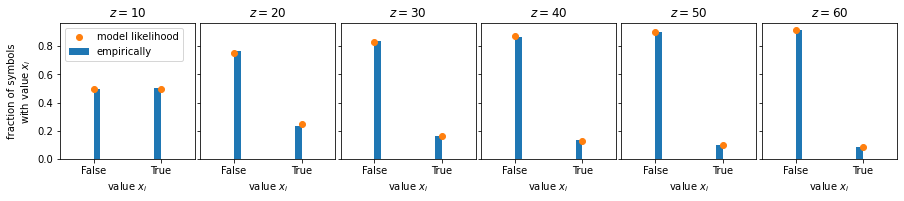

In [5]:
rng = np.random.RandomState(123) # Always set a random seed so that you can reproduce failing tests.

num_samples_per_z = 1000
samples_x = np.empty((len(domain_z), num_samples_per_z), dtype=np.int32)
fig, axs = plt.subplots(1, (len(domain_z) + 9) // 10, figsize=(15, 2.5), sharey=True)

for z_index, z in enumerate(domain_z):
    # Generate some samples from the likelihood P(X_i | Z=z) in the most naive way possible
    # so that we can be sure that these samples are generated corretly.
    for i in range(num_samples_per_z):
        samples_x[z_index, i] = (rng.choice(z) < 5)  # Note that `rng.choices(z)` returns a value from 0 to `z-1`.
    
    if z_index % 10 == 0:
        ax = axs[z_index // 10]
        ax.set_title(f'$z = {z}$')
        ax.hist(
            samples_x[z_index],
            weights=[1/num_samples_per_z] * num_samples_per_z, # Probably not the nicest way to do this but it works.
            label='empirically')
        ax.plot([0, 1], likelihood(domain_x, z), 'o', label='model likelihood')
        ax.set_xlabel('value $x_i$')
        ax.set_xlim(-0.5, 1.5)
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['False', 'True'])

axs[0].set_ylabel('fraction of symbols\nwith value $x_i$')
axs[0].legend(loc='upper left')
    
fig.subplots_adjust(wspace=0.04)

#### Your Task

Look at the above graphs and make sure you understand what they show (you'll probably have to refer to the code for this purpose).
Then make sure that you understand why the graphs are consistent with what we expect from the model.
In particular, you should notice:
- that the models (organge dots) match the empirical distributions (blue bars) up to small deviations that seem consistent with random noise;
- that the likelihood for $z=2$ looks like it's symmetric; why is that what we expect for the case $z=2$?
- that, for increasing $z$, both the empirical distribution and the likelihood start to favor the `False` symbol; why is that too consistent with our expectation?

### Problem 1 (c): Test Harness

As a final setup step, the following code defines a generic function to test a compression method.
Read the doc string and make sure you understand it, then move on to Problem 2, where you'll finally be able to get your hands dirty.

In [6]:
def test_compression_method(encode, decode, message_length=100):
    """Verify correctness and evaluate compression performance of an encoder-decoder pair.

    This function encodes several random messages from the model into a single bit string
    by repeatedly calling the provided callback `encode`. It then decodes all messages from
    the compressed bit string by repeatedly calling the provided callback `decode`, and it
    verifies that the decoded messages match the original messages. The function then
    returns the average bit rate per message (averaged over all tested messages).

    Thus, this function simulates a typical real-world scenario where you might use a
    channel to communicate not only a single message but a *sequence* of messages. Note
    that all sample messages are *independent* draws from the above probabilistic model.
    Thus, while the symbols *within each message* are all generated with the same latent $z$,
    the value $z$ will differ across messages. Therefore, the concatenation of the sample
    messages would not be distributed according to the probabilistic model. Again, this
    simulates the typical real-world scenario: if you were to communicate, e.g., a sequence
    of images, then you'd expect each individual image to show a consistent scene, but it
    would be unreasonable to assume that the concatenation of all images would also show
    a single scene.

    Args:
        encode: a function with the signature `encode(message, existing_compressed)`.
            Should compress the `message`, append the compressed bit string to
            `existing_compressed`, and then return the new (longer) compressed bit
            string.
        decode: a function with the signature `decode(compressed, num_symbols)`.
            Should decode `num_symbols` symbols from the *end* of the bit string
            `compressed` and return a tuple `(symbols, remaining)`, where `symbols`
            are the decoded symbols and `remaining` is any part of the original bit
            string `compressed` that was not used up by the decoding process.
        message_length: the number of symbols in each sample message (defaults to 100).

    Returns:
        float: the average bit rate per message.
    """

    assert message_length <= samples_x.shape[1]

    # Compress the messages, starting with no compressed data, and growing the buffer of
    # compressed data in each step.
    compressed = np.array([], dtype=np.uint32)
    for i, z in enumerate(domain_z):
        compressed = encode(samples_x[i, :message_length], compressed)

    total_bitrate = len(compressed) * 32 # `compressed` is an array of unsigned 32-bit integers.

    # Decompress the data and verify that this reconstructs the original messages. We iterate
    # *in reverse order* since we assume that the provided encoder-decoder pair operate as a stack.
    for i, z in reversed(list(enumerate(domain_z))):
        reconstructed, compressed = decode(compressed, message_length)
        assert np.all(reconstructed == samples_x[i, :message_length])

    return total_bitrate / len(domain_z)

## Various Compression Techniques

Problems 2-4 make up the meat of this problem set.
You'll implement three different techniques to encode data from the data source defined in Problem 1 above.
You'll start with a trivial technique in Problem 2 and then gradually increase the complexity in Problems 3 and 4.

## Problem 2: Compressing Without Considering Correlations

### Problem 2 (a): Define a Simplified Model of the Data Source

In the simplest way, we could just ignore the correlations between the symbols $X_i$ that result from the marginalization over the latent variable $Z$.
Thus, we don't actually use the true generative model $P$ from Problem 1 above as our entropy model for compression.
Instead, we will use a simplified model $P'$ that factorizes over all symbols,
\begin{align}
    P'(\mathbf{X}) = \prod_{i=1}^k P'(X_i)
\end{align}
and we simply encode all messages (regardless of the value of $Z$ that was used to generate them) by encoding each symbol with the entropy model $P'$.
We therefore don't even have to encode and transmit any value of $Z$ to the receiver.


#### Your Tasks

1. Show that the best choice for $P'(X_i)$ (i.e., the one that minimizes the expected bit rate) is the *marginal symbol distribution*,
\begin{align}
    P'(X_i) := \sum_{z=10}^{60} P(Z=z) \,P(X_i\,|\, Z=z).
\end{align}
2. Then implement the function `marginal_symbol_probability` below and verify that it returns the correct result when applied to `domain_x`.

In [7]:
def marginal_symbol_probability(x_i):
    # YOUR TASK: calculate P'(x_i) and return it. If `x_i` is an array of symbols rather than
    # a single symbol, then calculate P' of each symbol and return an array of the results.
    # (about 4 lines of code)

In [8]:
# should return `array([0.818539, 0.181461])`
marginal_symbol_probability(domain_x)

array([0.818539, 0.181461])

Looks reasonable, it's somewhere between the cases for $z=10$ and $z=60$ from the above figure.

### Problem 2 (b): Implement And Test the Encoder and Decoder

#### Your Task

Let's get real!
Implement a function `encode_independently` and `decode_independently` that encode and decode a message using the simplified entropy model $P'$.
These methods should behave as expected by the function `test_compression_method` defined in Problem 1 (c) above.
You may find it useful to refer back to Problem 1 (a) to refresh your memory of how to construct an `AnsCoder` with some existing compressed data, how to encode and decode some symbols with it, and how to get the compressed data out of an `AnsCoder`.

Once you've implemented both the encoder and the decoder, run the unit test as indicated below and make sure that it passes.

In [9]:
def encode_independently(message, existing_compressed):
    # YOUR TASK: fill in the function body (about 3-5 lines of code)

def decode_independently(compressed, num_symbols):
    # YOUR TASK: fill in the function body (about 3-5 lines of code)

In [10]:
# This should run without raising an exception and return an average bit rate of about 69
test_compression_method(encode_independently, decode_independently)

69.01960784313725

## Problem 3: Compressing With a Maximum A-Posteriori (MAP) Estimate of $Z$

In this problem, you will encode the message $\mathbf{x}=(x_1,x_2,\ldots,x_k)$ with a more accurate model than the simplified model $P'$ from Problem 2.
To do this, you will exploit the fact that all symbols $x_i$ within a given message were created by a random process that used the *same* value $z$ for the latent variable $Z$.
Thus, the likelihood $P(\mathbf X|Z=z)$ should be a better model for encoding the messages.

Unfortunately, the receiver doesn't know which $z$ was used to generate the message.
Thus, you'll have to encode and transmit not only the message $\mathbf x$ but also the value $z$ of the latent variable $Z$.

While the *sender* might know the true value of $Z$ that was used during the generation of the message (depending on the circumstances of how our compression method gets deployed), knowing this value on the *sender* side doesn't actually help.
All we want to achieve is to compress a given message $\mathbf x$ into as short a bit string as possible.
The fact that we have to transmit some value for $Z$ to do this is more of a nuissance, and nobody forces us to transmit the value of $Z$ that was actually used in the generative process.
Therefore, instead of using the "ground truth" value of $Z$, we will use the value $z^*$ that minimizes the resulting bit rate.
As we discussed in the lecture, we get $z^*$ by minimizing the *joint* information content with a fixed message $\mathbf x$,

\begin{align}
    z^* &= \arg\min_z \big[-\log P(\mathbf X=\mathbf x, Z=z) \big]
    = \arg\max_z \big[ \log P(\mathbf X=\mathbf x, Z=z) \big].
\end{align}

Note that:
- The logarithm may *seem* unnecessary for taking the $\arg\max$, but it is important in practice because it prevents numerical underflow as $P(\mathbf X=\mathbf x\,|\, Z=z) = \prod_{i=1}^k P(X_i=x_i\,|\,Z=z)$ is exponentially small in $k$.)
- As discussed in the lecture, the solution $z^*$ is also called the *maximum a-posteriori* (MAP) solution since maximizing the joint over the latent variable $z$ is equivalent to maximizing the *posterior distribution*, $P(Z\, |\, \mathbf{X}=\mathbf{x}) = P(\mathbf X=\mathbf x, Z)\,/\, P(\mathbf X=\mathbf x)$ (because the posterior and the joint only differ by the positive multiplicative factor $P(\mathbf X=\mathbf x)$, is a constant for any given message $\mathbf x$).

#### Your tasks

1. Implement the function `map_estimate` below which takes an array of symbols `xs`.
2. Make sure you didn't make any obvious mistake by running the code below that tests `map_estimate` on some of our sample messages and generates a visualization of the results.
3. Then implement an encoder and decoder (similar to Problem 2) and test them.
   - Remember that, in this problem, you have to transmit both the message $\mathbf x$ and the latent variable $z^*$, and you'll need to use different entropy models for the two. You should have experience in this kind of task from solving Problem 1 (a).
   - Also remember that the `AnsCoder` that we're using here is a *stack*. So you'll have to encode first $\mathbf x$ and then $z^*$ because the decoder will have to decode $z^*$ first so it can use it to construct the entropy model for decoding $\mathbf x$. (For this problem, you could also use a `constriction.stream.queue.RangeEncoder`, which operates as a queue, but Problem 4 below will be much easier to solve with a stack.)

In [11]:
def log_joint_probability(xs, z):
    # This is already provided for you. You don't need to change it (but you should understand it!)
    return np.log(prior(z)) + np.sum(np.log(likelihood(xs, z)))

def map_estimate(xs):
    # YOUR TASK: fill in the function body (1 line of code if you know the numpy function to call;
    # maybe 4 lines of code otherwise)

Check that you didn't make any obvious mistake:

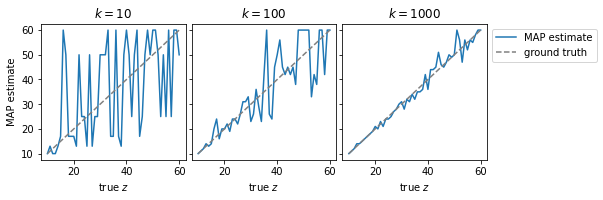

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(8, 2.5), sharey=True)

for ax, message_length in zip(axs, [10, 100, 1000]):
    map_estimates = [map_estimate(samples_x[i, :message_length]) for i in range(len(domain_z))]
    ax.set_title(f'$k={message_length}$')
    ax.plot(domain_z, map_estimates, label='MAP estimate')
    ax.plot(domain_z, domain_z, '--', c='gray', label='ground truth')
    ax.set_xlabel('true $z$')

axs[0].set_ylabel('MAP estimate')
axs[-1].legend(loc='upper left', bbox_to_anchor=(1, 1))
fig.subplots_adjust(wspace=0.04)    

You should see that the MAP estimate is close to the ground truth for long messages (right plot) but the two may be very different for short messages (left plot).
This is to be expected since short messages are more susceptible to noise, so a message generated with $Z=z$ may, by coincidence, actually look more *as if* it had been generated with some different $Z=z^*$.
In such a case, it would be foolish to compress the message with the entropy model $P(\mathbf X|Z=z)$ since you'll get a lower bit rate with the entropy model $P(\mathbf X|Z=z^*)$.

In [13]:
def encode_map(message, existing_compressed):
    # YOUR TASK: fill in the function body (about 4-8 lines of code)

def decode_map(compressed, num_symbols):
    # YOUR TASK: fill in the function body (about 4-8 lines of code)

In [14]:
# This should run without raising an exception and return again average bit rate of about 69.
# You'll do a more thorough quantitative comparison between the different methods in Problem 5 below.
test_compression_method(encode_map, decode_map)

69.6470588235294

## Problem 4: Bits-Back Coding

You'll now implement the bits-back coding algorithm.
This compression method is similar to the method you implemented in Problem 3.
However, instead of setting $Z$ to the MAP estimate, the encoder will sneak some side information into the chosen value of $Z$.
This side information can be any bit string, e.g., some previously compressed message.

### Problem 4 (a): Bayesian Infernence (i.e., Obtain the Posterior Distribution)

As discussed in the lecture, the first step of bits-back coding is to perform Bayesian inference.
Thus, given a message $\mathbf x$ that you want to compress, you have to find the *posterior probability distribution*,

\begin{align}
    P(Z\, |\, \mathbf{X}=\mathbf{x})
    &= \frac{P(\mathbf X=\mathbf x,Z)}{P(\mathbf X=\mathbf x)}
    = \frac{P(Z)\, P(\mathbf X=\mathbf x\, |\, Z)}{\sum\limits_{z'} P(Z=z')\, P(\mathbf X=\mathbf x\, |\, Z=z')}
\end{align}

#### Your task

1. Implement a function `posterior_probabilities`, which takes an array of symbols `xs` (the "s" is again for plural here) and which returns an array of floats of length `len(domain_z)`, which sums up to one (up to rounding errors) and which lists the posterior probabilities $P(Z=z\, |\, \mathbf{X}=\mathbf{x})$ for all $z\in\{10, 11, \ldots, 60\}$.
2. Then run the code below that tests `posterior_probabilities` on some sample messages and generates a visualization of the results. Check if the plots look plausible as explained underneath the plots.

In [15]:
def posterior_probailities(xs):
    # YOUR TASK: fill in the function body (about 5 lines of code)

Let's evaluate the posterior probability $P(Z\, |\, \mathbf{X}=\mathbf{x})$ on several sample messages $\mathbf{x}$ and compare it to the MAP approximation:

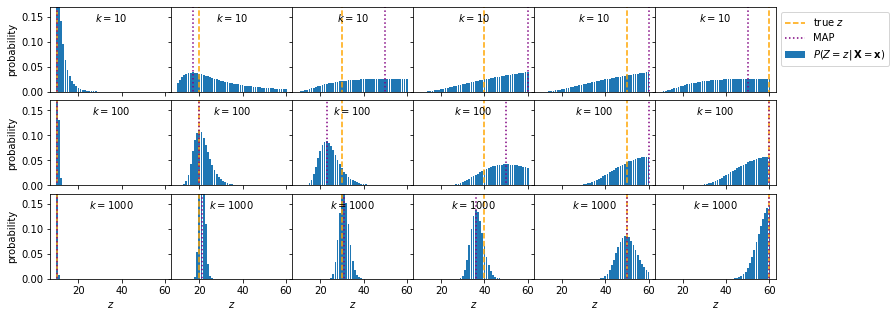

In [16]:
fig, axs = plt.subplots(3, (len(domain_z) + 9) // 10, figsize=(13, 5), sharex=True, sharey=True)

for i, message_length in enumerate([10, 100, 1000]):
    for z_index, z in enumerate(domain_z):
        message = samples_x[z_index, :message_length]
        posterior = posterior_probailities(message)
        map_result = map_estimate(message)
        
        if z_index % 10 == 0:
            ax = axs[i, z_index // 10]
            ax.text(.5,.83, f'$k={message_length}$', horizontalalignment='center', transform=ax.transAxes)
            ax.bar(domain_z, posterior, label='$P(Z=z \,|\, \mathbf{X}=\mathbf{x})$')
            ax.plot([z] * 2, [-1, 2], '--', c='orange', label='true $z$')
            ax.plot([map_result] * 2, [-1, 2], ':', c='purple', label='MAP')
            ax.set_ylim(0, .17)

            if i == 2:
                ax.set_xlabel('$z$')
            if z_index == 0:
                ax.set_ylabel('probability')
            
axs[0,-1].legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.subplots_adjust(hspace=0.1, wspace=0)

**Looking at the above plots, you should find that:**
- The MAP estimate (dotted purple vertical line) sits indeed always at the maximum of the posterior distribution (blue bars).
- The posterior distribution is very broad throughout the upper row, where we conditioned on messages of only length $k=10$. This is plausible since, the fewer symbols we have, the more uncertain we are about which parameter $z$ was used to generate the symbols.
  By contrast, the posterior becomes sharper towards the lower rows, where $k$ grows, i.e., where we condition on more data.
- Overall, the posterior distribution shifts to the right as the ground truth (dashed orange vertical line) moves to the right. In particular, in the last row ($k=1000$), the posterior alwayas has a clearly discernible peak, and the ground truth always lies within the peak).

### Problem 4 (b): Bits-Back Coding

Now implement the bits-back coding method.
As discussed in the lecture, the **encoder** should do the following:
1. construct an `AnsCoder` from the provided bit string `existing_compressed`;
2. *decode* (no typo) some of those bits into $z$ using the posterior $P(Z\, |\, \mathbf X=\mathbf x)$;
3. encode the message $\mathbf x$, where the entropy model is the likelihood $P(\mathbf X\, |\, Z=z)$ with $z$ being the value decoded in step 2;
4. encode $z$ using the prior model $P(Z)$;
5. return the (entire) compressed data that's now on the `AnsCoder`;

And the **decoder** should reverse the steps of the encoder, in reverse order (since the coder is a stack).

#### Your tasks

Fill in the blanks in the function bodies below and then run the unit test.

In [17]:
def encode_bitsback(message, existing_compressed):
    coder = constriction.stream.stack.AnsCoder(existing_compressed)
    if len(existing_compressed) != 0:
        # YOUR TASK: decode a latent variable `z` using the posterior distribution
    else:
        # Bits-back coding expects some side information that it uses to set `z`. If no side
        # information is available yet (the "initial bits problem"), then we'll just set `z` to
        # the map estimate (like in Problem 3) since that's the best we can do in this situation.
        # Note that the *decoder* can't possibly know that we didn't use any side information,
        # so it will still generate some side information, which we can simply ignore.
        z = map_estimate(message)

    # YOUR TASK: fill in the rest of the bits-back encoder (about 3-5 lines of code)

def decode_bitsback(compressed, num_symbols):
    # YOUR TASK: fill in the function body (about 6-10 lines of code)

In [18]:
# This should run without raising an exception and return again average bit rate of about 66.
# You'll do a more thorough quantitative comparison between the different methods in Problem 5 below.
test_compression_method(encode_bitsback, decode_bitsback)

65.88235294117646

# Problem 5: Quantitative Evaluation and Comparison of the Three Methods

In Problems 2, 3, and 4, you've implemented three different methods for compressing data from the same data source.
Let's now compare how well these three methods perform as a function of the message length $k$:

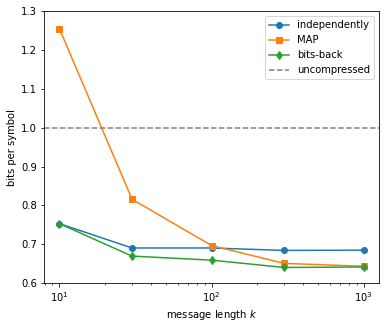

In [19]:
test_lengths = [10, 30, 100, 300, 1000]
bitrates_independently = [
    test_compression_method(encode_independently, decode_independently, message_length) / message_length
    for message_length in test_lengths]
bitrates_map = [
    test_compression_method(encode_map, decode_map, message_length) / message_length
    for message_length in test_lengths]
bitrates_bitsback = [
    test_compression_method(encode_bitsback, decode_bitsback, message_length) / message_length
    for message_length in test_lengths]

fig, ax = plt.subplots(figsize=(6, 5))
ax.set_xscale('log')
ax.plot(test_lengths, bitrates_independently, 'o-', label='independently')
ax.plot(test_lengths, bitrates_map, 's-', label='MAP')
ax.plot(test_lengths, bitrates_bitsback, 'd-', label='bits-back')
xlims = ax.get_xlim()
ax.plot(xlims, [1, 1], '--', color='gray', label='uncompressed')
ax.set_xlim(xlims)
ax.set_ylim(0.6, 1.3)
ax.set_xlabel('message length $k$')
ax.set_ylabel('bits per symbol')
ax.legend()

#### Your tasks

You should be able to understand pretty much every aspect about the above plot.
Explain the following observations:
- Why do all methods become more effective (i.e., the bit rate per symbol drops) as the message length $k$ grows? (This is important to understand for the MAP and the bits-back method; for the "independent" method, it is just due to a small constant overhead of the coder, which becomes a bottleneck for very small $k$.)
- How is it possible that "compression" with the MAP method (orange curve) actually *increases* the file size over the uncompressed representation (dotted gray line) for very low $k$? (Hint: think about the extreme case of $k=1$: what does the MAP method transmit in this case?)
- Why does the compression performance of the MAP method (orange curve) approach the bits-back performance (green curve) in the limit $k\to\infty$?
- In the limit $k\to\infty$, all curves seem to converge to two different constant values. What are these constants (express both of them as entropies of something under some probabilistic model)?
  In particular, the fact that you were able to outperform the "independent" method—which would be the *optimal* compression method if the symbols were statistically independent (i.e., uncorrelated)—demonstrates that the symbols $X_i$ that our latent variable model produces really are correlated (I believe this was another source of confusion in the lecture).

**Note:** if you decrease the message length even further then you will get very noisy results because you'll then average over very little data (also, the coder has a small constant overhead of about 32 bits, which will become a bottleneck for very small $k$). Already in the above plot, the fact that the "bits-back" curve and the "independent" curve seem to meet at $k=10$ does not have any fundamental reason.

## Obligatory Final Remark

Please don't forget to provide feedback to this problem set in the poll on moodle!